In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit

def corr2(c1,c2): # cross-correlation
    c1-=c1.mean()
    c2-=c2.mean()
    c12=(c1*c1).sum()*(c2*c2).sum()
    if c12>0.0:
        return (c1*c2).sum()/np.sqrt(c12)
    return -1.0

def fixer(vecx,vecy,vec,rij,r_limit,i_fix): # fixing the irregular vectors
    fluc=np.zeros(vec.shape)
    for j in range(1,vec.shape[1]-1):
        for i in range(1,vec.shape[0]-1):
            neigh_x=np.array([])
            neigh_y=np.array([])
            for ii in range(-1,2):
                for jj in range(-1,2):
                    if ii==0 and jj==0: continue
                    neigh_x=np.append(neigh_x,vecx[i+ii,j+jj])
                    neigh_y=np.append(neigh_y,vecy[i+ii,j+jj])
            res_x=neigh_x-np.median(neigh_x) # residual
            res_y=neigh_y-np.median(neigh_y)
            
            res_s_x=np.abs(vecx[i,j]-np.median(neigh_x))/(np.median(np.abs(res_x))+0.1) # Normalized Residual
            res_s_y=np.abs(vecy[i,j]-np.median(neigh_y))/(np.median(np.abs(res_y))+0.1)
            
            fluc[i,j]=np.sqrt(res_s_x*res_s_x+res_s_y*res_s_y) # Normalized Fluctuations
    # plt.contourf(fluc,levels=np.arange(2,200,0.1))#,vmin=0.0,vmax=2
    # plt.colorbar(label='Normalized Fluctuation')
    
    i_disorder=0
    for ii in range(i_fix): # Correction Cycle
        i_disorder=0
        vec_diff=0.0
        for j in range(1,vec.shape[1]-1):
            for i in range(1,vec.shape[0]-1):
                if fluc[i,j]>2.0 or (rij[i,j]<r_limit): 
                    i_disorder+=1
                    vecx[i,j]=0.25*(vecx[i+1,j]+vecx[i-1,j]+vecx[i,j+1]+vecx[i,j-1])
                    vecy[i,j]=0.25*(vecy[i+1,j]+vecy[i-1,j]+vecy[i,j+1]+vecy[i,j-1])
                    vec_diff+=(vec[i,j]-np.sqrt(vecx[i,j]*vecx[i,j]+vecy[i,j]*vecy[i,j]))**2.0
                    vec[i,j]=np.sqrt(vecx[i,j]*vecx[i,j]+vecy[i,j]*vecy[i,j])
                    
        if i_disorder==0 or vec.mean()==0.0: break 
        correction_residual=vec_diff/(i_disorder*np.abs(vec.mean()))
        if correction_residual<1.0e-20: break # Converged!
    if ii==i_fix-1: print("Maximum correction iteration was reached!")
    return vecx,vecy,vec,i_disorder,ii


def subpix(R,axis): # Subpixel resolution
    dum=np.floor(np.argmax(R)/R.shape[0])    
    R_x=int(dum) #vecy
    R_y=int(np.argmax(R)-dum*R.shape[0])  #vecx
    r=R[R_x,R_y]
    if np.abs(r-1.0)<0.01: return 0.0
    try: # Out of bound at the edges:
        if axis == 'y': #For vecy
            r_e=R[R_x+1,R_y]
            r_w=R[R_x-1,R_y]
        else:          #For Vecx
            r_e=R[R_x,R_y+1]
            r_w=R[R_x,R_y-1]
        if r_e>0.0 and r_w>0.0 and r>0.0: # Gaussian
            r_e=np.log(r_e)
            r_w=np.log(r_w)
            r=np.log(r)
        if (r_e+r_w-2*r)!=0.0:
            if np.abs((r_w-r_e)/(2.0*(r_e+r_w-2*r)))<1.0 and np.abs(r_e+1)>0.01 and np.abs(r_w+1)>0.01:
                return (r_w-r_e)/(2.0*(r_e+r_w-2*r))
        return 0.0
    except:
        return 0.0

img_1 = (np.flip(cv2.imread('../assets/image4.jpg', 0),0)).astype('float32') # Read Grayscale
img_2 = (np.flip(cv2.imread('../assets/image5.jpg', 0),0)).astype('float32')

i_fix=500     # Number of maximum correction cycles
r_limit=0.5   # minimum acceptable correlation coefficient
l_scale=1.0   # spatial scale [m/pixel]
t_scale=1.0   # time step = 1/frame_rate [s/frame]

iw=51 # Interrodation Windows Sizes (pixel)
sw=81 # Search Windows Sizes (sw > iw) (pixel)

#Search Algorithm:
ia,ja = img_1.shape
iw=int(2*np.floor((iw+1)/2)-1) # Even->Odd
sw=int(2*np.floor((sw+1)/2)-1)
margin=int((sw-iw)/2)
im=int(2*np.floor((ia-1-iw)/(iw-1))) # Number of I.W.s in x direction
jm=int(2*np.floor((ja-1-iw)/(iw-1))) # Number of I.W.s in y direction

vecx=np.zeros((im,jm)) # x-Displacement
vecy=np.zeros((im,jm)) # y-Displacement
vec=np.zeros((im,jm)) # Magnitude
rij=np.zeros((im,jm)) # Correlation coeff.

for j in tqdm(range(jm)):
    j_d=int(j*(iw-1)/2) # Bottom bound
    j_u=j_d+iw          # Top bound
    sw_d=max(0,j_d-margin) # First Row
    sw_d_diff=max(0,j_d-margin)-(j_d-margin)
    sw_u=min(ja-1,j_u+margin) # Last Row
    
    for i in range(im):
        i_l=int(i*(iw-1)/2) # Left bound
        i_r=i_l+iw          # Right bound
        sw_l=max(0,i_l-margin) # First column
        sw_l_diff=max(0,i_l-margin)-(i_l-margin)
        sw_r=min(ia-1,i_r+margin) # Last column
        
        R=np.zeros((sw-iw+1,sw-iw+1))-1 # Correlation Matrix
        c1=np.array(img_1[i_l:i_l+iw,j_d:j_d+iw]) # IW from 1st image
        for jj in range(sw_d,sw_u+1-iw):
            for ii in range(sw_l,sw_r+1-iw):
                c2=np.array(img_2[ii:ii+iw,jj:jj+iw]) # IW from 2nd image
                R[ii-sw_l,jj-sw_d]=corr2(c1,c2)
        rij[i,j]=R.max()
        if rij[i,j]>=r_limit:
            dum=np.floor(np.argmax(R)/R.shape[0])
            vecy[i,j]=dum-(margin-sw_l_diff)+subpix(R,'y')
            vecx[i,j]=np.argmax(R)-dum*R.shape[0]-(margin-sw_d_diff)+subpix(R,'x')
            vec[i,j]=np.sqrt(vecx[i,j]*vecx[i,j]+vecy[i,j]*vecy[i,j])
        else:
            vecx[i,j]=0.0;vecy[i,j]=0.0;vec[i,j]=0.0
        
vecx,vecy,vec,i_disorder,i_cor_done=fixer(vecx,vecy,vec,rij,r_limit,i_fix)

X, Y = np.meshgrid(np.arange(0.5*iw, 0.5*iw*(jm+1), 0.5*iw), 
                   np.arange(0.5*iw, 0.5*iw*(im+1), 0.5*iw))
X*=l_scale
Y*=l_scale
vecx*=(l_scale/t_scale);vecy*=(l_scale/t_scale);vec*=(l_scale/t_scale);
np.savez('results.csv', vecx=vecx, vecy=vecy, vec=vec, rij=rij)
# res=np.load('results.npz'); vecx=res['vecx']; vecy=res['vecy']; vec=res['vec']; rij=res['rij']; # Load saved data

100%|██████████| 22/22 [00:23<00:00,  1.06s/it]


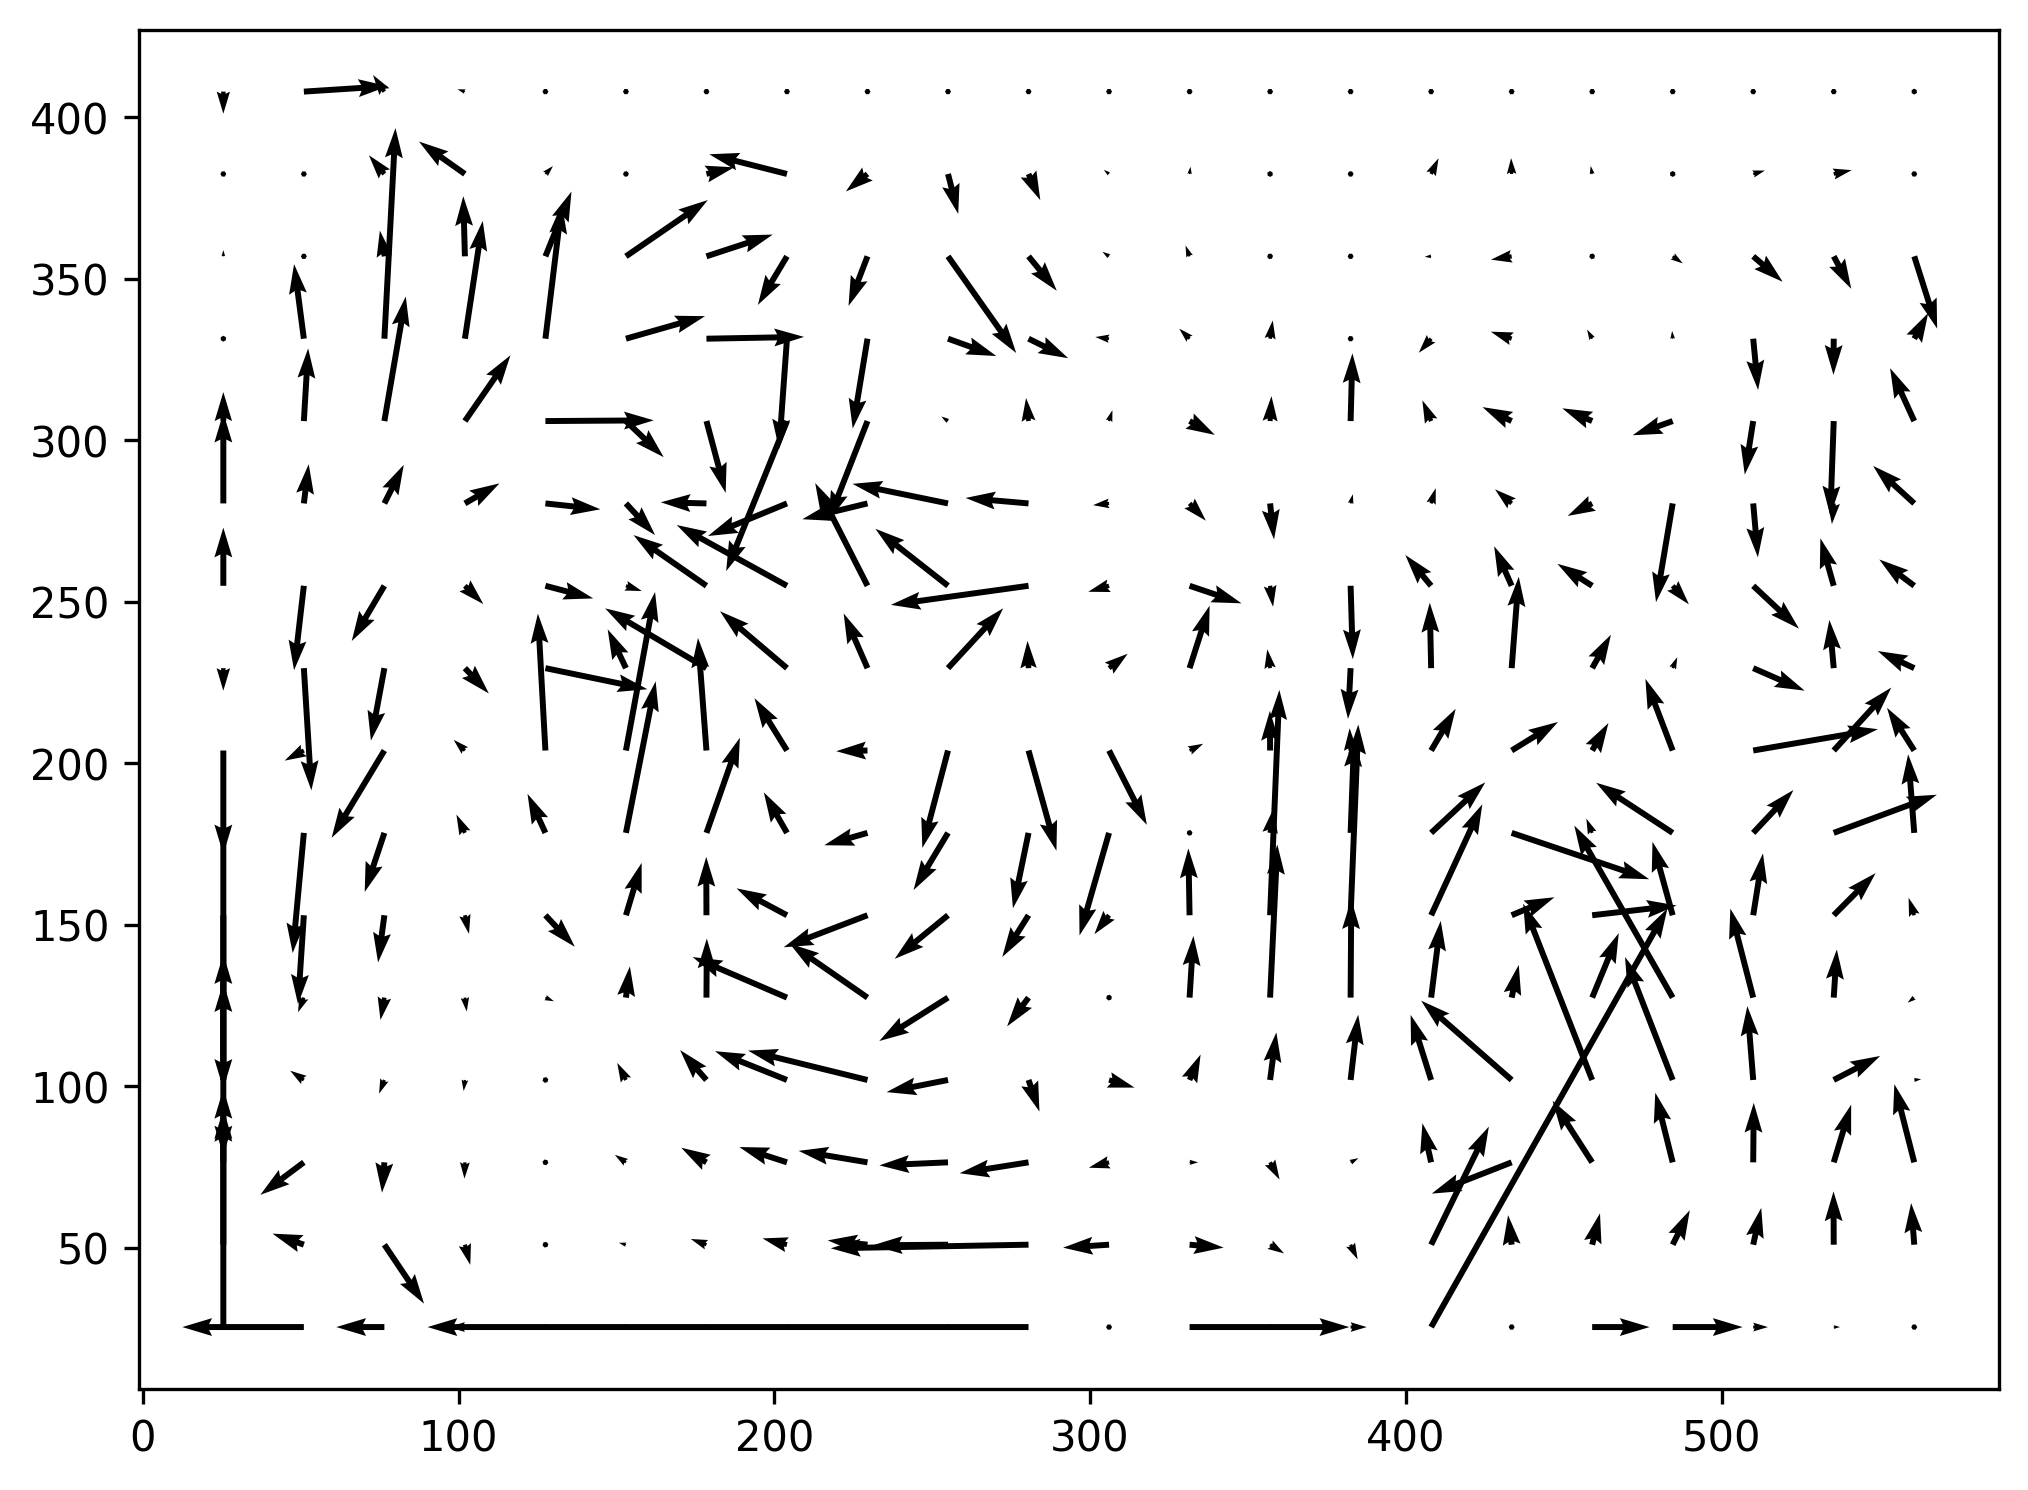

In [2]:
fig, ax = plt.subplots(figsize=(8,8*ia/ja), dpi=300)
q = ax.quiver(X, Y, vecx, vecy,units='width')
plt.show()

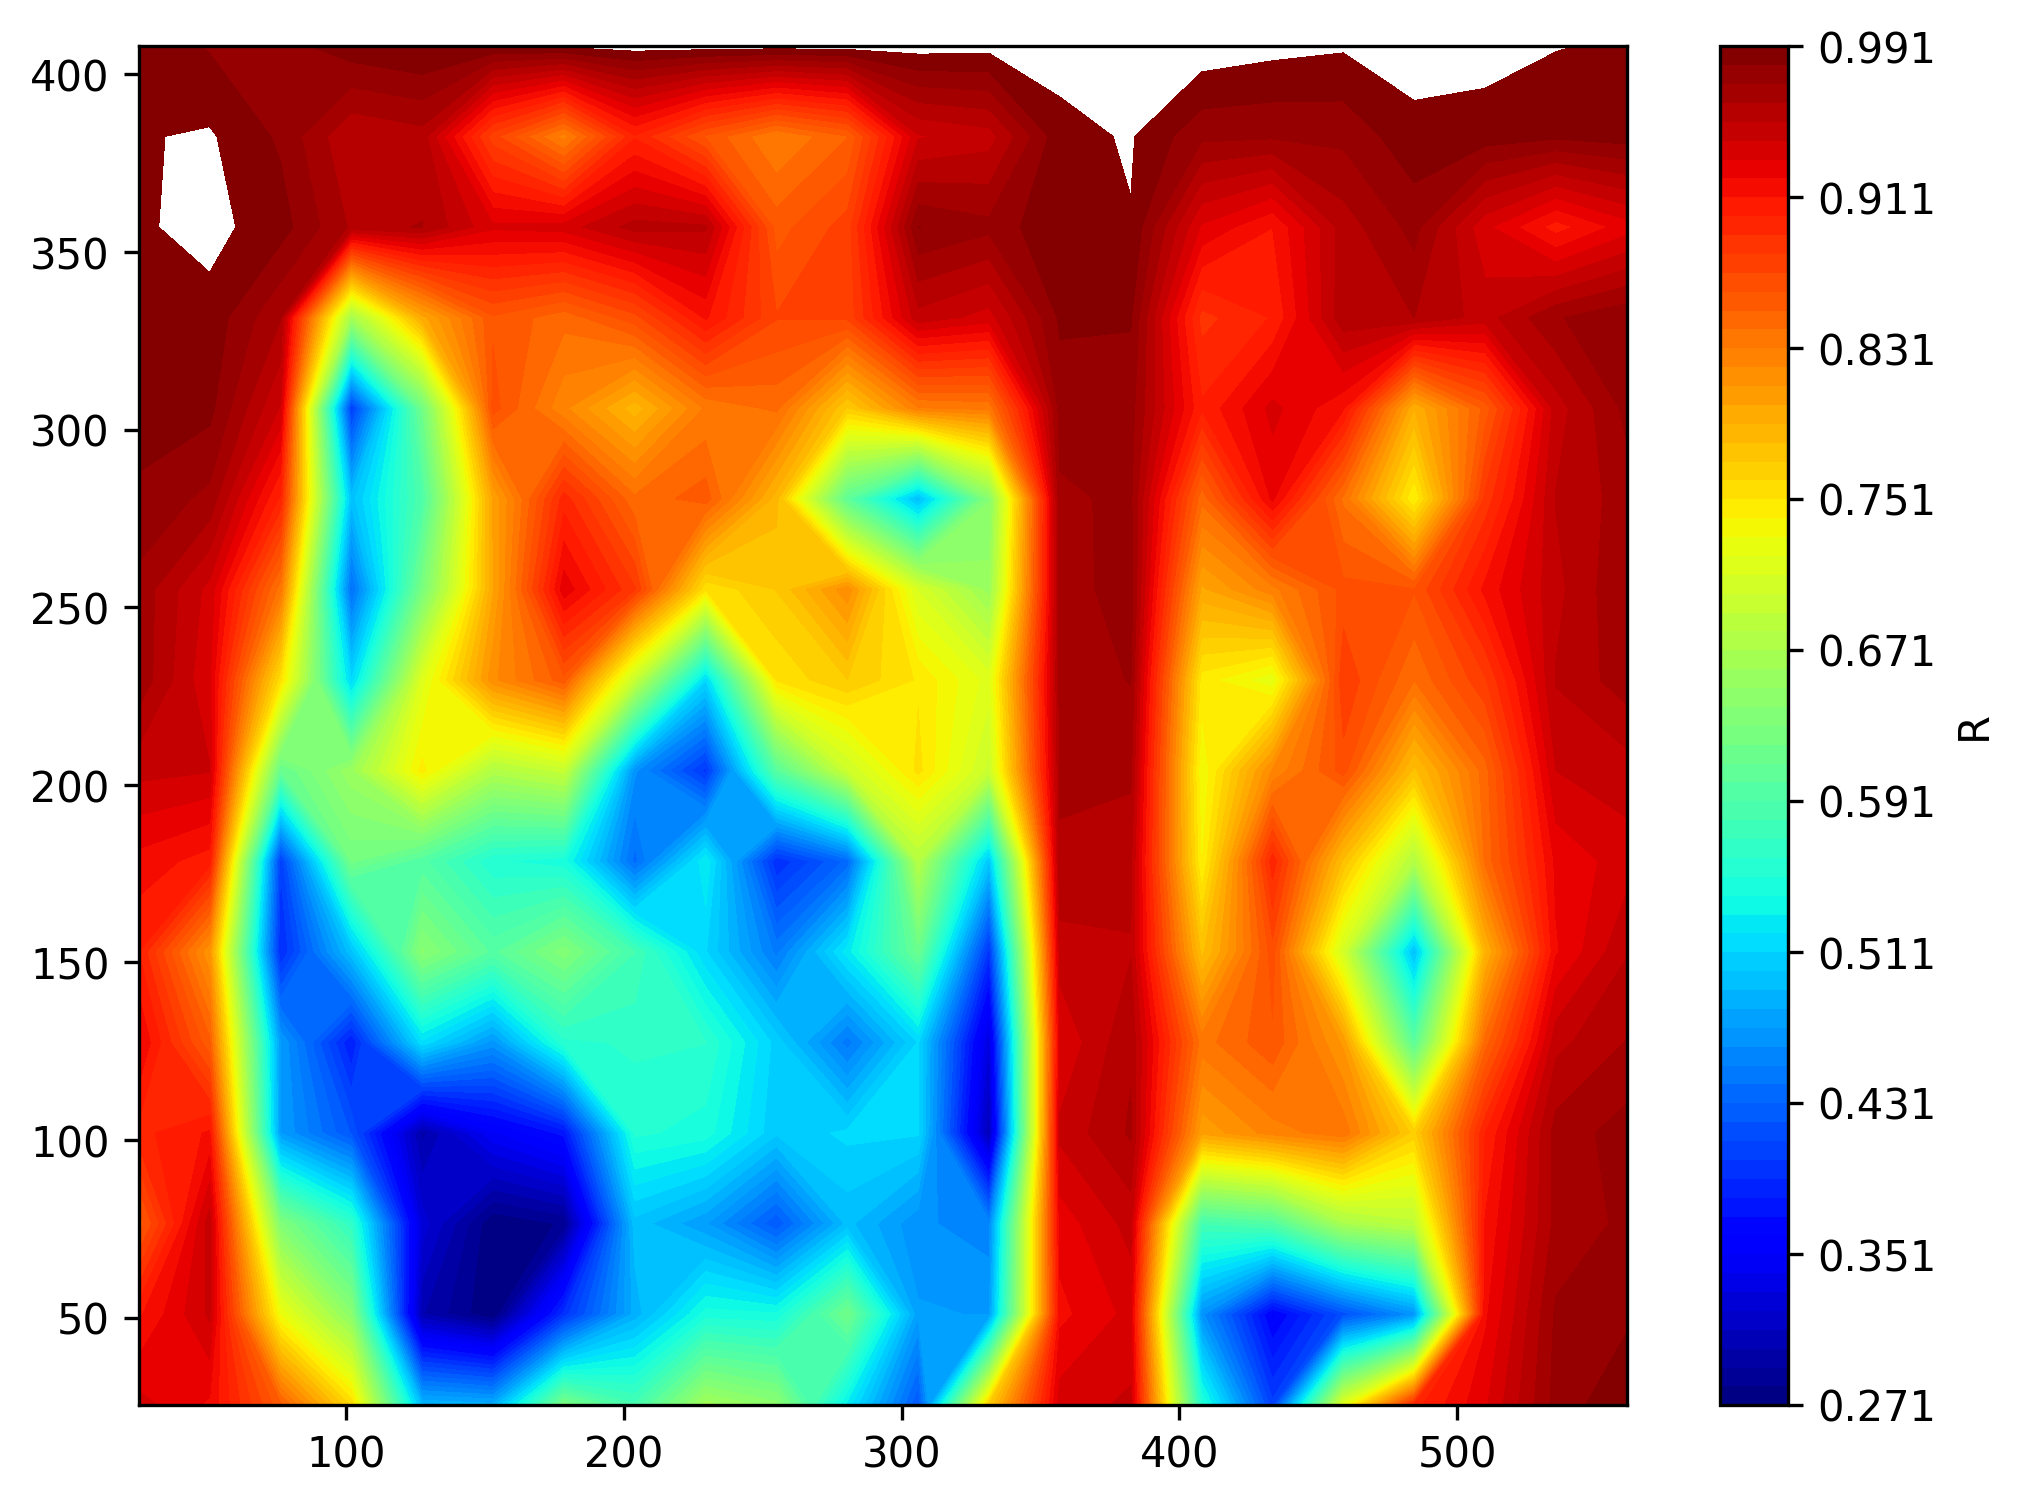

In [3]:
fig, ax = plt.subplots(figsize=(8,8*ia/ja), dpi=300)
plt.contourf(X[0],np.transpose(Y)[0],rij,cmap='jet',levels=np.arange(rij.min(),min(rij.max()+0.1,1.0),0.01))
plt.colorbar(label='R')
plt.show()

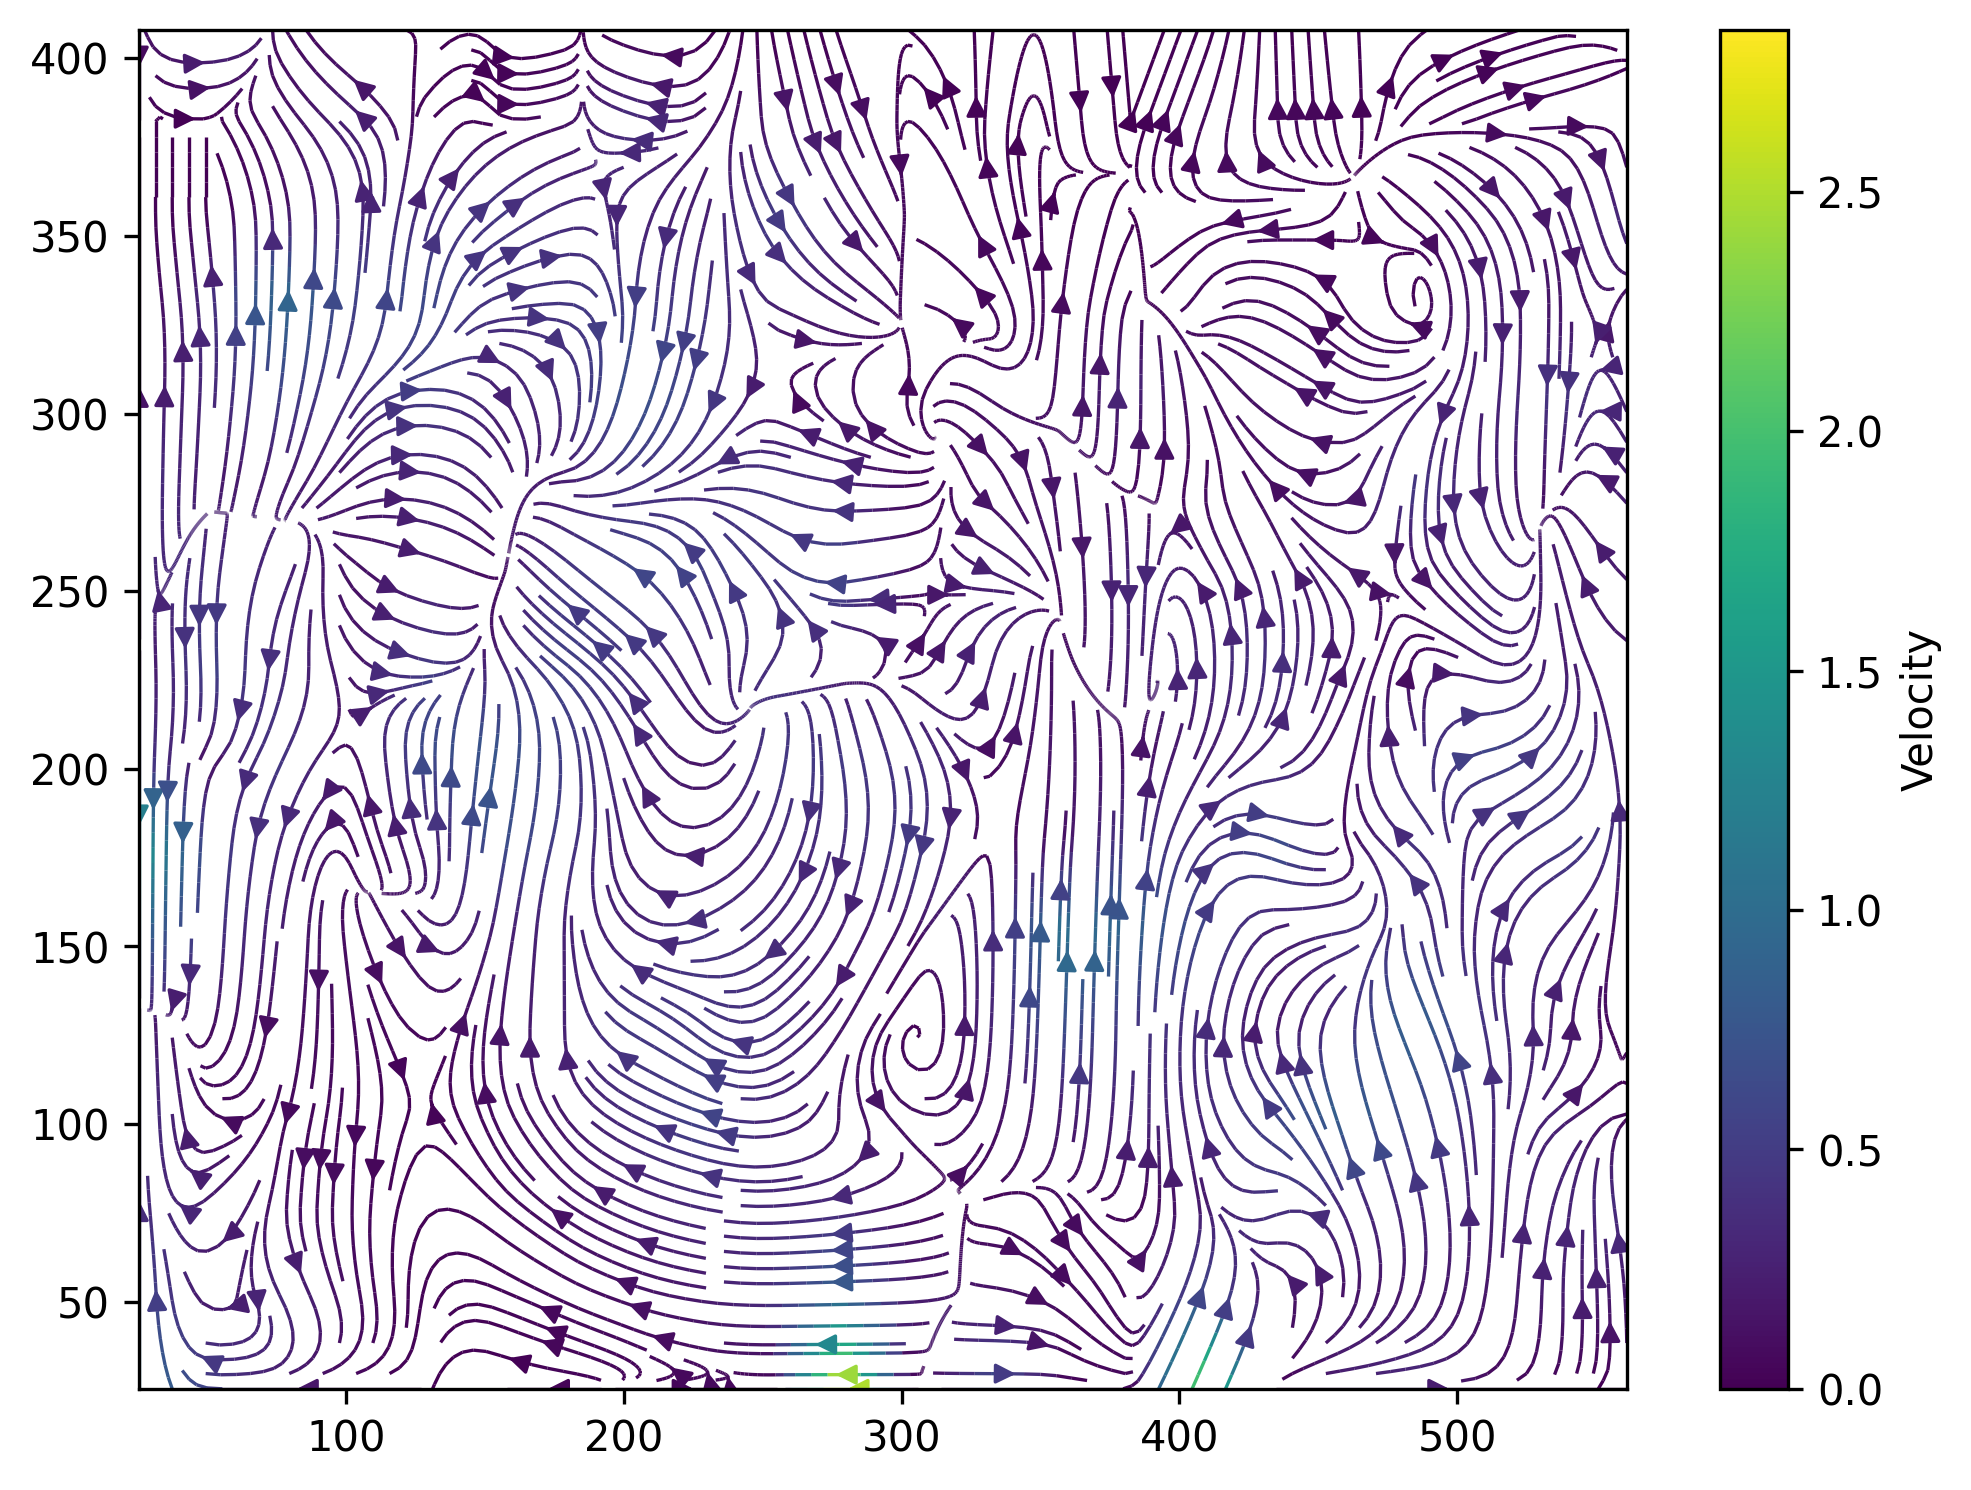

In [4]:
fig, ax = plt.subplots(figsize=(8,8*ia/ja), dpi=300)
plt.streamplot(X, Y, vecx, vecy,density=3,linewidth=0.8,color=vec)
plt.colorbar(label='Velocity')
plt.show()